<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/FtStewartSampleDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fort Stewart SGA sample design example

### This notebook demonstrates how Raseter Tools and ancillary data can be used to reduce estimation error and inform aspects of sample design. Datasets used in this notebook include raster surfaces created in [Using forest inventory data with Landsat 8 imagery to map longleaf pine forest characteristics in Georgia](https://www.mdpi.com/2072-4292/11/15/1803).

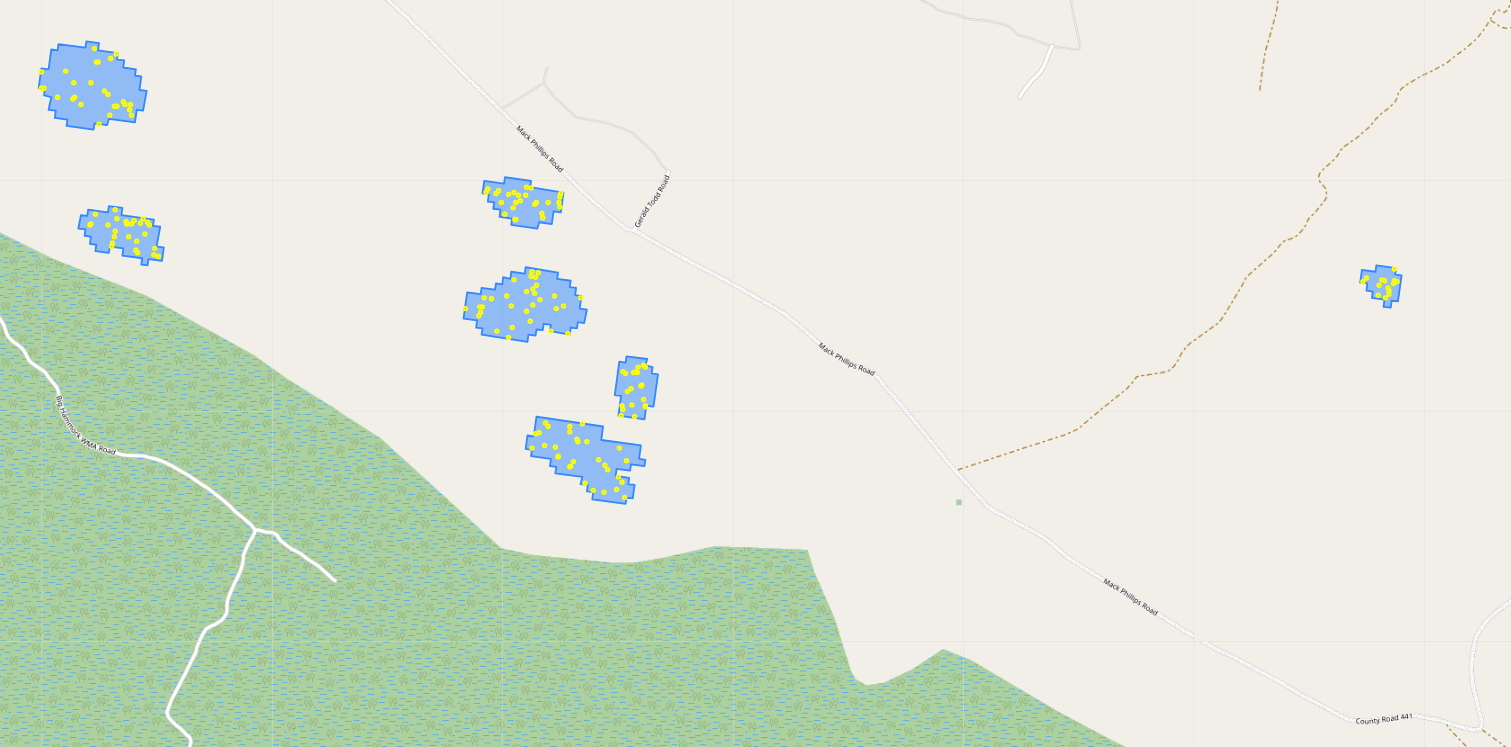

### Dataset can be manually downloaded from https://www.fs.usda.gov/rds/archive/catalog/RDS-2018-0039.
  
#### Author: John Hogland 5/22/2023

## Overview
#### Modeled estimates of needle and broad leaf basal area (ft<sup>2</sup> acre<sup>-1</sup>) and stem counts (acre <sup>-1</sup>) derived in [Hogland et al. 2019](https://www.mdpi.com/2072-4292/11/15/1803) will be used to define potential longleaf restoration units, design a sample, estimate sample size, and identify sample location within the Ft. Stewart significant geographic area (SGA). To help navigate these steps the notebook has been split into five sections:
1. Installing software
2. Downloading the data
3. Identifying potential restoration stands
4. Estimating a sample size
5. Allocating plots

### Install software
#### This step is meant to install Raster Tools and upgrade various packages on [Google's Colab](https://colab.research.google.com/). If working locally and raster tools has already been installed, this step can be skipped.

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install leafmap xarray_leaflet
!pip install localtileserver
!pip install raster_tools

### Download the data
#### To download the data for this notebook run the cell below. After downloading the data from the RDS archives and extracting the zipped contents you will have a ".\data" directory containing each of the raster surfaces created within the [Hogland et al. 2019](https://www.mdpi.com/2072-4292/11/15/1803) study. To view the metadata open the _metadata_RDS-2018-0039.html file

#### Files we will be using in this notebook include:
- B_BAA = Broadleaf basal area (ft<sup>2</sup> acre<sup>-1</sup>)
- N_BAA = Needle-leaf basal area (ft<sup>2</sup> acre<sup>-1</sup>)
- B_TPA = Broadleaf stems (ha<sup>-1</sup>)
- N_TPA = Needle-leaf stems (ha<sup>-1</sup>)
- N_Leaf = Neele-leaf classification (1=present, 0=absent)
- B_Leaf = Broad-leaf classification (1=present, 0=absent)
- FtStewartSGA = Ft Stewart Significant Geographic Area (SGA)

In [ ]:
import gdown, zipfile

url='https://www.fs.usda.gov/rds/archive/products/RDS-2018-0039/RDS-2018-0039.zip' #raster data
url2='https://drive.google.com/file/d/1KSj7DfDd_GrrplJJASRMQRFBa5zyXaQ2/view?usp=sharing' #SGA boundary

outfl = r"./SGA_Notebook_data.zip"
outfl2= "./SGA_bndy.zip"

gdown.download(url=url, output=outfl, quiet=False, fuzzy=True)
gdown.download(url=url2, output=outfl2, quiet=False, fuzzy=True)

with zipfile.ZipFile(outfl, "r") as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile(outfl2, "r") as zip_ref:
    zip_ref.extractall(".")

#### Let's visualize the significant geographic area (SGA) boundary and the raster surfaces using [Folium](https://python-visualization.github.io/folium/)

In [ ]:
from localtileserver import get_folium_tile_layer, TileClient #TileClient, get_leaflet_tile_layer
#from ipyleaflet import Map, LayersControl, basemaps, basemap_to_tiles, GeoData, Polygon
from raster_tools import open_vectors
import folium

# Specify the name of the predictor raster stack
outname1 = "./Data/B_BAA.tif"
outname2 = "./Data/N_BAA.tif"
outname3 = "./Data/B_TPA.tif"
outname4 = "./Data/N_TPA.tif"
outname5 = "./FtStewartSGA.shp"

# Create a TileClient from a raster file
client1 = TileClient(outname1)
client2 = TileClient(outname2)
client3 = TileClient(outname3)
client4 = TileClient(outname4)


# Create ipyleaflet TileLayer from that server
t1 = get_folium_tile_layer(client1, band=[1], name="B_BAA (ft squared/acre)",overlay=True, vmin=5,vmax=150,palette='viridis',nodata=0,show=False)
t2 = get_folium_tile_layer(client2, band=[1], name="N_BAA (ft squared/acre)",overlay=True,vmin=5,vmax=150,palette='viridis',nodata=0)
t3 = get_folium_tile_layer(client3, band=[1], name="B_TPA (ft squared/acre)",overlay=True, vmin=5,vmax=500,palette='cividis',nodata=0,show=False)
t4 = get_folium_tile_layer(client4, band=[1], name="N_TPA (ft squared/acre)",overlay=True, vmin=5,vmax=500,palette='cividis',nodata=0,show=False)

# Load SGA shape file
geoDf=open_vectors(outname5).data.compute()


# Create folium map, add tile layer, and display
m=geoDf.explore(name='Ft Stewart SGA',color='orange',style_kwds={"fillOpacity":0})

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)



m.add_child(t1)
m.add_child(t2)
m.add_child(t3)
m.add_child(t4)

# add layer controls to the map
folium.LayerControl().add_to(m)
m

### Identifying potential restoration stands. Stands or contiguous regions that are in need of restoration have both a needle and broad leaf basal area component. Historically, these sites had less of a broad leaf component due to frequent fire but now broad leaf species dominant the overstory  
#### Steps
1. Read in data, address null values, Convert basal area values to m<sup>2</sup> ha<sup>-1</sup> and stem counts to ha<sup>-1</sup>
2. Perform various spatial analyses defined in **Table 1** to identify potential restoration sites.
3. Summarize stands BAH estimates
3. Estimate sample size for each polygon using stand summaries
4. Visualize the results


<h4 style="text-align: center;">
    <b>Table 1.</b> Modeling procedure and Criteria used to identify restoration stands.
</h4>
   
|Model|Surface|Criteria|
|:-:|:-:|:-:|
|1|Needle-leaf BAH Threshold|$$ N_BAH > 3 $$|
|2|Broadleaf  BAH Threshold|$$ B_BAH > 10 $$|
|3|QMD|$$ \sqrt{\frac{BAH}{0.0000785 * TPH}} > 12.5 (cm) $$|
|4|Cell Selection|model1 & model2 & model3|
|5|Smooth|focal(model4,mode,9,9)|
|6|Regions|regions(model5,neighbors=8)|
|7|Stands|20,000 < model6 regions area < 1,000,000

#### Step 1: Read in data, address null values, convert to BAH and TPH

In [ ]:
%%time
from raster_tools import Raster, focal, general, creation, zonal, Vector, open_vectors
import numpy as np

# BAA and TPA surfaces are dependent on needle and broad leaf presence (hurdle model)
# As such we will be using N_leaf and B_Leaf to truncate BAA and TPA surfaces values

#read in the data and set null values to 0
n_pres=Raster('./Data/N_Leaf.tif')
n_pres=n_pres.where(Raster(~n_pres.xmask),0)

b_pres=Raster('./Data/B_Leaf.tif')
b_pres=b_pres.where(Raster(~b_pres.xmask),0)

nb_check=n_pres * b_pres #needs to have both needle and broad leaf present

b_baa=Raster('./Data/B_BAA.tif')
b_baa=b_baa.where(Raster(~b_baa.xmask),0)
b_bah=(nb_check*b_baa*0.229568).eval() # multiplier used to convert baa to bah

n_baa=Raster('./Data/N_BAA.tif')
n_baa=n_baa.where(Raster(~n_baa.xmask),0)
n_bah=(nb_check*n_baa*0.229568).eval()  # multiplier used to convert baa to bah

b_tpa=Raster('./Data/B_TPA.tif')
b_tpa=b_tpa.where(Raster(~b_tpa.xmask),0)
b_tph=(b_tpa * 0.404686 * nb_check) # multiplier used to convert per acre to per hectare

n_tpa=Raster('./Data/N_TPA.tif')
n_tpa=n_tpa.where(Raster(~n_tpa.xmask),0)
n_tph=(n_tpa * 0.404686 * nb_check) # multiplier used to convert per acre to per hectare

tph = (n_tph+b_tph).eval() # add tph surfaces to get total tph
bah = (n_bah+b_bah).eval() # add bah surfaces to get total bah


#### Step 2. Spatial analyses

In [ ]:
%%time
#model steps 1-5

qmd=((bah/(0.000785*tph))**0.5).eval()
cs=((n_bah>3) & (b_bah>10) & (qmd>12.5)).astype('int32') # cell selection criteria
s=focal.focal(cs,'mode',9,9).astype('int32').eval() #smooth out selections

In [ ]:
%%time
del tph, b_bah, n_bah, qmd, cs


#create regions
r=general.regions(s,neighbors=8,unique_values=[1]).eval()

#convert m squared to cells
res_x,res_y=np.abs(r.resolution)
cellsize=res_x*res_y
min_cells = 20000/cellsize
max_cells = 1000000/cellsize

#select regions
vls,cnts=np.unique(r,return_counts=True)
s_vls=vls[(cnts<min_cells) | (cnts>max_cells)]
rdic=dict(zip(s_vls,[0]*s_vls.shape[0]))
reg=r.reclassify(rdic).astype('int32').eval()
vls2=vls[~np.isin(vls,s_vls)]

#### Step 3: Summarize stand

In [ ]:
#summarize by zones and add id field
zstats=zonal.zonal_stats(reg,bah,['mean','std','count'],vls2).compute()
zstats['id']=vls2

del s, r, bah

##### Convert regions to polygons and visualize mean BAH

In [ ]:
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape

from geopandas import GeoDataFrame
from pandas import DataFrame

data = reg.values
msk = (data>0).astype('bool')

# Use a generator instead of a list
shape_gen = ((shape(s), v) for s, v in shapes(data, mask=msk, connectivity=8,transform=reg.affine))

# build a dict from unpacked shapes
gdf = GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))), crs=reg.crs)


##### Join polygons with summary stats and visualize

gdf['id']=gdf['id'].astype('int32')
zstats['id']=zstats['id'].astype('int32')
s_gdf=gdf.join(zstats.set_index('id'),on='id')
s_gdf.explore(column='mean')

#### Step 4. Estimate sample sizes for each polygon using expansion and modeled methods.

In [ ]:
from scipy import stats
from matplotlib import pyplot as plt

# get stand statistics and calculate n using n=1/((P/100)^2/(t_(n-1(a))^2 (s_reg/▁y)^2 )+1/N) and substituting expanded and modeled standard deviations fro s-reg

# set parameters
P = 10
m = s_gdf['mean']
N = s_gdf['count']
alpha = 0.05
t = stats.t.ppf(1-(alpha/2), N-1) # two tailed t-statistic for each stand @ alpha = 0.05 ((1-alpha)/2)

#expand sd using % variation explained
exp_s = s_gdf['std']/(1-0.521) #R squared of 0.521 was taken from Needle-leaf BAH in Hogland et al. 2019 (Table 2)
cv_expanded = exp_s/m #calculate cv

#replace sd using RMSE from the model
mdl_s = 6.4 #RMSE from Needle-Leaf BAH in Hogland et al. 2019 (Figure 7)
cv_modeled = mdl_s/m #calculate cv

#calculate n and add to data frame
s_gdf['n_expanded'] = 1/((P/100)**2/((t**2)*(cv_expanded**2))+1/N)
s_gdf['n_model'] = 1/((P/100)**2/((t**2)*(cv_modeled**2))+1/N)

#plot n for the modeled estimate and explore the polygon
f, axes = plt.subplots(figsize=(20, 6), ncols=2, nrows=1, tight_layout=True)
cnt = 0
clms = ["n_model", "n_expanded"]
for x in clms:
    s_gdf[x].plot(ax=axes[cnt],kind='hist')
    axes[cnt].set_title('Sample Size for ' + x, fontdict={"fontsize": 25, "fontweight": 3})
    cnt += 1


##### Allocating random sample locations

In [ ]:
from shapely import geometry

#create a function to allocate locations randomly with a polygon
def get_random_sample(geom_p, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    geom_p = (polygon) project polygon
    n = number of observations

    returns: list of points

    """
    xmin, ymin, xmax, ymax = geom_p.bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = geometry.Point([x, y])
        if pnt.intersects(geom_p):
            pnts_lst.append(pnt)

    return pnts_lst

#create a list to hold points for each method
plst_ex=[]
plst_md=[]
for t in s_gdf.itertuples():
    geo=t.geometry
    n_ex=np.round(t.n_expanded).astype('int32')
    n_mdl=np.round(t.n_model).astype('int32')
    plst_ex+=get_random_sample(geo,n_ex)
    plst_md+=get_random_sample(geo,n_mdl)

ex_gdf=GeoDataFrame({"geometry": plst_ex}, crs=s_gdf.crs)
md_gdf=GeoDataFrame({"geometry": plst_md}, crs=s_gdf.crs)

#### Step 5: Visualize plots and stand boundaries


In [ ]:
import folium
from folium.plugins import MousePosition

m1=s_gdf.explore(name="restoration stands",location=(32.02,-81.63),zoom_start=13) # zoom into a polygon at 32.02,-81.63
m2=md_gdf.explore(m=m1,name="modeled sample design",color='yellow')
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m2)
MousePosition().add_to(m2)
folium.LayerControl().add_to(m2)
m2


##### Note that for some polygons the modeled sample size is larger than the expanded sample size. This is due to the variability within stand estimated BAH. On average, though, model based sample size (21) is smaller than expanded based sample size (36). Run the cell below to see summary statistics of the s_gdf geodataframe.

In [ ]:
#look at summary statistics for stands
s_gdf.describe()

# This ends the Ft. Stewart SGA sample design notebook
## Check out the other notebooks:
- https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/README.md
## References
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html